In [3]:
# default_exp utils_challenge

# Libraries 

In [1]:
#export
import numpy as np
from scipy.optimize import linear_sum_assignment
import pandas
from tqdm.auto import tqdm
import warnings


In [4]:
import matplotlib.pyplot as plt
# from andi_datasets.utils_challenge import *

# Filtering labels

Here we treat the labels extracted from `models_phenom` such as to have smoother ones. For instance, we will define a minimum segment length.

In [3]:
#export
def majority_filter(seq, width):
    offset = width // 2
    seq = [0] * offset + seq
    return [max(set(a), key=a.count) 
        for a in (seq[i:i+width] for i in range(len(seq) - offset))]

def label_filter(label, window_size = 5, min_seg = 3):
    
    if np.min(label) < 0:
        raise ValueError('This function only works with positive labels')
        
    # if there are no changes:
    if np.sum(label[1:] != label[:-1]) == 0:
        return label
    
    # define dummy vector with all zeros and ones
    values, dummy = np.unique(label, return_inverse = True)
    
    # check if there are segment smaller than minimal segment (min_seg)
    cp = np.argwhere(dummy[1:] != dummy[:-1])
    cp = np.append(0, cp)
    current_min = (cp[1:]-cp[:-1]).flatten().min()

    while (current_min < min_seg):

        filt = majority_filter(dummy.tolist(), width = window_size)
        filt = np.array(filt)
        
        # check if there are segment smaller than minimal segment (min_seg)
        cp = np.argwhere(filt[1:] != filt[:-1])
        
        # If all changepoints were eliminated
        if cp.size == 0:
            break
            
        cp = np.append(0, cp)
        current_min = (cp[1:]-cp[:-1]).flatten().min()
        
        if (dummy == filt).all():  
            # If all failed and still have segments smaller than min_seg
            seg_lengths = (cp[1:]-cp[:-1]).flatten().astype(int)
            seg_smaller = np.argwhere(seg_lengths < min_seg).flatten()
            
            # We over each segment and we asign the values 'by hand'
            for idxsegs in seg_smaller:     
                if seg_lengths[idxsegs] == 1:
                    filt[(cp[idxsegs]+1)] = filt[cp[idxsegs]]     
                elif seg_lengths[idxsegs] == 2:      
                    filt[(cp[idxsegs]+1)] = filt[cp[idxsegs]]     
                    filt[(cp[idxsegs]+2)] = filt[cp[idxsegs]+3]                     
            
            dummy = filt
            break         
        dummy = filt
        
        
    # Check boundaries
    if dummy[0] != dummy[1] or dummy[1] != dummy[2]:
        dummy[:2] = dummy[2]
    if dummy[-2] != dummy[-3] or dummy[-1] != dummy[-2]:
        dummy[-3:] = dummy[-3]
        
    # reset to label values
    dummy_ret = np.zeros_like(dummy).astype(float)
    
    for idx, v in enumerate(values):
        dummy_ret[dummy == idx] = v

    return dummy_ret

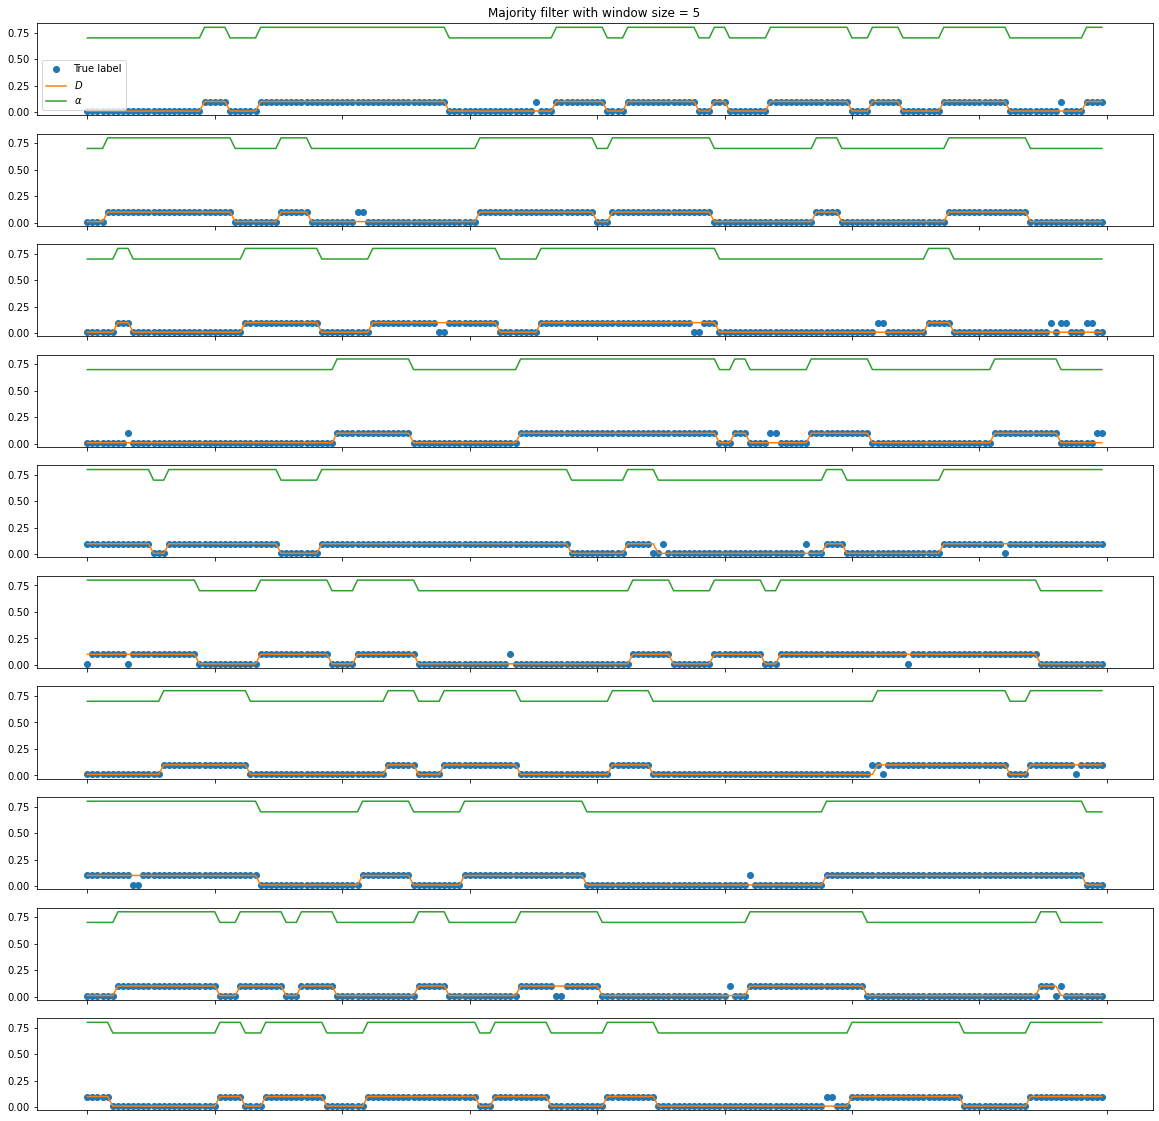

In [87]:
from andi_datasets.models_phenom import models_phenom

fig, axs = plt.subplots(10, 1, figsize = (20, 20))
window_size = 5

for ax in axs:    
    traj, labs = models_phenom._multiple_state_traj(alphas = [0.7, 0.8], Ds = [0.01, 0.1])
    filtered_d = label_filter(labs[:,1])
    filtered_a = label_filter(labs[:,0])
    
    ax.plot(labs[:, 1], 'o', label = 'True label')
    ax.plot(filtered_d, label = r'$D$')
    ax.plot(filtered_a, label = r'$\alpha$')
    
axs[0].set_title(f'Majority filter with window size = {window_size}')
axs[0].legend()
plt.setp(axs, xticklabels = []);

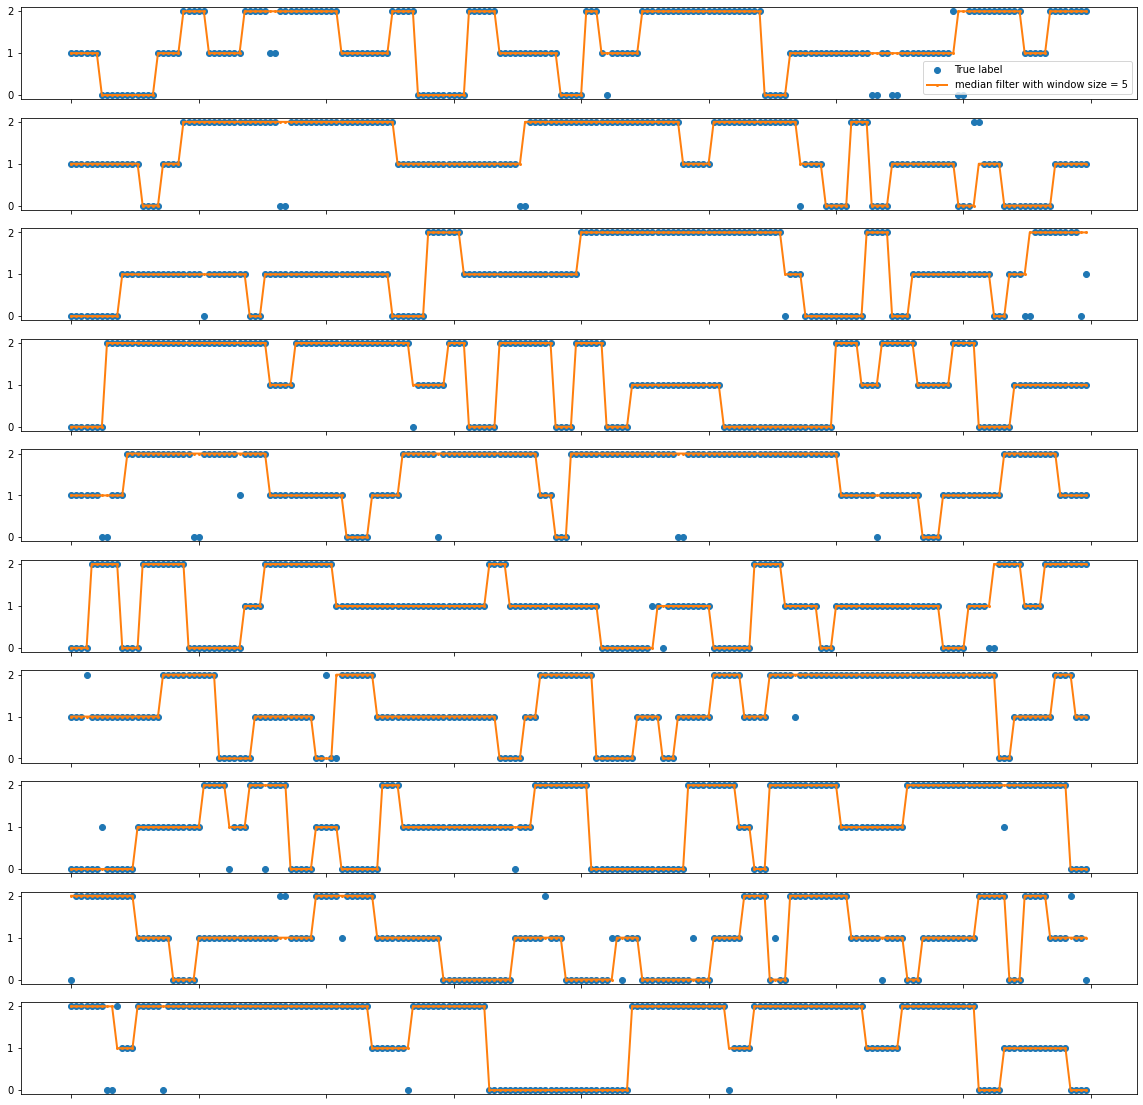

In [86]:
fig, axs = plt.subplots(10, 1, figsize = (20, 20))
filt_size = 5

M = [[0.8, 0.1, 0.1],[0.05, 0.9, 0.05], [0.05, 0.05, 0.9]]
alphas = [0.7, 1, 1.2]
Ds = [0, 1, 2]

for ax in axs:    
    traj, labs = models_phenom._multiple_state_traj(alphas = alphas, Ds = Ds, M = M)
    filtered = label_filter(labs[:,1], window_size=filt_size)
    
    ax.plot(labs[:, 1], 'o', label = 'True label')
    ax.plot(filtered, 'o-', ms = 2, label = f'median filter with window size = {filt_size}', lw = 2)
axs[0].legend()
plt.setp(axs, xticklabels = []);

## Calculating new transition rates after filtering

In [4]:
from andi_datasets.models_phenom import models_phenom

T = 1000
traj, labs = models_phenom().multi_state(N = 500, alphas = [0.7, 1], Ds = [0, 1], T = T)

NameError: name 'label' is not defined

In [5]:
from tqdm.notebook import tqdm

res_t = np.array([])
res_ft = np.array([])
for label in tqdm(labs.transpose(1,0,2)[:,:,0]):
    
    # raw labels
    CP = np.argwhere(label[1:] != label[:-1]).flatten()
    if CP[-1] != 199: CP = np.append(CP, T-1)
    CP = np.append(0, CP)

    res_t = np.append(res_t, CP[1:] - CP[:-1])
    
    
    # filtered labels
    filt = label_filter(label)
    
    CP_f = np.argwhere(filt[1:] != filt[:-1]).flatten()
    if CP_f[-1] != 199: CP_f = np.append(CP_f, T-1)
    CP_f = np.append(0, CP_f)

    res_ft = np.append(res_ft, CP_f[1:] - CP_f[:-1])

  0%|          | 0/500 [00:00<?, ?it/s]

In [41]:
print(f' True transition rate: {1/np.mean(res_t)}\n',
      f'Filtered transition rate: {1/np.mean(res_ft)}\n',
      f'True rate x 2/3: {1/np.mean(res_t)*(2/3)}')

 True transition rate: 0.10091711711711712
 Filtered transition rate: 0.06881721721721722
 True rate x 2/3: 0.06727807807807808


In [22]:
1/0.10091711711711712

9.909121748290453

In [21]:
1/0.06881721721721722

14.5312472726638

## From step-wise labels to list of properties

In [760]:
# export
def stepwise_to_list(labels):
    
    l_alpha = labels[:, 0]
    l_D = labels[:, 1]

    # Check if there are changes in any of the variables
    CP_D = np.argwhere(l_D[1:] != l_D[:-1]).flatten()+1
    CP_alpha = np.argwhere(l_alpha[1:] != l_alpha[:-1]).flatten()+1

    # if there are only changes in D
    if CP_D.shape[0] > CP_alpha.shape[0]:
        CP_D = np.append(CP_D, l_D.shape[0])
        Ds = l_d[CP_D.flatten()-1]
        alphas = np.ones_like(Ds)*l_alpha[0]
        return CP_D[:-1], Ds, alphas
        

    # only changes in alpha
    elif CP_D.shape[0] < CP_alpha.shape[0]:
        CP_alpha = np.append(CP_alpha, l_alpha.shape[0])    
        alphas = l_alpha[C_alpha.flatten()-1]
        Ds = np.ones_like(alphas)*l_d[0]
        return CP_alpha[:-1], Ds, alphas

    # Same CP for both
    else:
        CP_D = np.append(CP_D, l_D.shape[0])
        Ds = l_D[CP_D.flatten()-1]
        alphas = l_alpha[CP_D.flatten()-1]        
        return CP_D[:-1], Ds, alphas

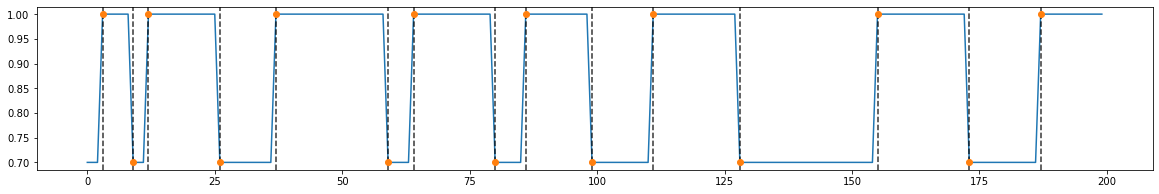

In [757]:
traj, labs = models_phenom._multiple_states_traj(alphas = [0.7, 1], Ds = [0, 1])

filt_alpha = label_filter(labs[:,0])
filt_D = label_filter(labs[:,1])

CP, Ds, alphas = stepwise_to_list(np.vstack((filt_alpha, filt_D)).transpose())

fig, ax = plt.subplots(figsize = (20, 3))
ax.plot(filt_alpha, zorder = -1)
for idx, cp in enumerate(CP): 
    ax.axvline(cp, c = 'k', ls = '--', alpha = 0.8, zorder = -1)
    plt.scatter(cp, alphas[idx+1], c = 'C1', zorder = 2)

# Continuous labels to list of features

The labels in the challenge will be the list of $n$ changepoints as well as the $n+1$ diffusion properties ($D$ and $\alpha$) for each segment. This function transforms the stepwise labels into three lists: CPs, $\alpha$s and $D$s.

### `continuous_label_to_list`

In [244]:
# export
def continuous_label_to_list(labs):
    ''' Given an array of T x 2 labels containing the anomalous exponent and diffusion 
    coefficient at each timestep, returns 3 arrays, each containing the changepoints, 
    exponents and coefficient, respectively. 
    If labs is size T x 3, then we consider that diffusive states are given and also
    return those.
        '''
    # Check if states were given
    are_states = False
    if labs.shape[1] == 3:
        are_states = True
        
    # Check in which variable there is changes
    CP = np.argwhere((labs[:-1, :] != labs[1:, :]).sum(1) != 0).flatten()+1 
    T = labs.shape[0]    

    alphas = np.zeros(len(CP)+1)
    Ds = np.zeros(len(CP)+1)
    if are_states: states = np.zeros(len(CP)+1)
    for idx, cp in enumerate(np.append(CP, T)):
        alphas[idx] = labs[cp-1, 0]
        Ds[idx] = labs[cp-1, 1]
        if are_states: states[idx] = labs[cp-1, 2]
    
    if are_states:
        return CP, alphas, Ds, states
    else:
        return CP, alphas, Ds    

Text(0, 0.5, '$\\alpha$')

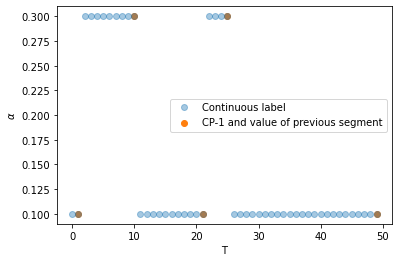

In [75]:
CP, alphas, Ds = continuous_label_to_list(labels[:,-1,:])
plt.plot(labels[:, -1, 0], 'o', alpha = 0.4, label = 'Continuous label')
plt.scatter(np.append(CP, T) -1, alphas, c = 'C1', label = 'CP-1 and value of previous segment')
plt.legend(); plt.xlabel('T'); plt.ylabel(r'$\alpha$')

# Storing data in DataFrame

### `data_to_df`

In [14]:
#export
from andi_datasets.utils_trajectories import segs_inside_fov
from andi_datasets.datasets_phenom import datasets_phenom

def data_to_df(trajs, 
               labels,
               label_values,
               diff_states,
               min_length = 10,
               fov_min = 0,
               fov_max = 1000):
    '''
    Inputs:
    :trajs (dimension: T x N x2):
    :labels (dimension: T x N x 2):
    :label_values (array) (size: # of states): values of any property for every existing state.
    :diff_states (array) (size: # of states): labels correspoding to each state as defined in the
    ANDI 2022 state labels: 0: immobile; 1: confined; 2: brownian; 3: anomalous.
    
    Outputs:
    :df_in (dataframe): dataframe with trajectories
    :df_out (datafram): datafram with label and information
    '''
    
    xs = []
    ys = []
    idxs = []   
    
    df_out = pandas.DataFrame(columns = ['traj_idx', 'T', 'Ds', 'alphas', 'states', 'changepoints']) 
    
    idx_t = 0
    for traj, l_alpha, l_D in zip(tqdm(trajs), labels[:, :, 0], labels[:, :, 1]):

        # Check FOV and 
        idx_inside_segments = segs_inside_fov(traj, fov_max, fov_min, min_length)

        if idx_inside_segments is not None:

            for idx_in in idx_inside_segments:            
                seg_x = traj[idx_in[0]:idx_in[1], 0]
                seg_y = traj[idx_in[0]:idx_in[1], 1]
                seg_alpha = l_alpha[idx_in[0]:idx_in[1]]
                seg_D = l_D[idx_in[0]:idx_in[1]]

                # Filtering
                seg_alpha = label_filter(seg_alpha)
                seg_D = label_filter(seg_D)
                
                seg_state = datasets_phenom()._extract_state(label_values = label_values,
                                                             states = diff_states,
                                                             labels = seg_alpha)
                
                # Stacking data of input dataframe
                xs += seg_x.tolist()
                ys += seg_y.tolist()
                idxs += (np.ones(len(seg_x))*idx_t).tolist()
                
                # Transforming to list of changepoints and physical properties
                merge = np.hstack((seg_alpha.reshape(seg_alpha.shape[0], 1),
                                   seg_D.reshape(seg_D.shape[0], 1),
                                   seg_state.reshape(seg_state.shape[0], 1)))
                
                CP, alphas, Ds, states = continuous_label_to_list(merge)
                
                # Saving each segment info in output dataframe
                df_out.loc[df_out.shape[0]] = [idx_t, len(seg_x), Ds, alphas, states, CP]
                
                # Updating segment index
                idx_t += 1

    
    # Saving trajectories in Dataframe
    tr_to_df = np.vstack((idxs,
                          xs,
                          ys)).transpose()
    df_in = pandas.DataFrame(tr_to_df, columns = ['traj_idx', 'x', 'y'])  
    
    return df_in, df_out

In [15]:
from andi_datasets.models_phenom import models_phenom

trajs, labels = models_phenom().multi_state(T = 200, N = 10, alphas=[0.5, 1], Ds = [1,1], L = 100)

trajs = trajs.transpose((1, 0, 2)).copy()
labels = labels.transpose(1, 0, 2)

In [16]:
df_in, df_out = data_to_df(trajs, labels, label_values=[0.5, 1], diff_states=[3, 2])

  0%|          | 0/10 [00:00<?, ?it/s]

c:\users\gorka\github\andi_datasets_dev\andi_datasets\utils_trajectories.py:247: RuntimeWarning: All-NaN slice encountered
  merge_dims = np.nanmin(np.vstack((x, y)), axis = 0)


# Challenge 2022 metrics

## Changepoint pairing
We use an assignment algorithm to pair predicted and groundtruth changepoints. From there, we will calculate the various metrics of the challenge.

#### `changepoint_assignment`

In [4]:
#export
def changepoint_assignment(GT, preds):
    ''' Given a list of groundtruth and predicted changepoints, solves the assignment problem via
    the Munkres algorithm (aka Hungarian algorithm) and returns two arrays containing the index of the
    paired groundtruth and predicted changepoints, respectively.'''
    
    cost_matrix = np.zeros((len(GT), len(preds)))

    for idxg, gt in enumerate(GT):
        for idxp, pred in enumerate(preds):
            cost_matrix[idxg, idxp] = np.abs(gt-pred)
            
    return linear_sum_assignment(cost_matrix), cost_matrix

#### `jaccard_index`

In [9]:
#export
def jaccard_index(TP, FP, FN):
    '''Given the true positive, false positive and false negative rates, calculates the Jaccard Index'''
    return TP/(TP+FP+FN)

#### `ensemble_changepoint_error`

In [34]:
#export
def ensemble_changepoint_error(GT_ensemble, pred_ensemble, threshold = 5):    
    ''' Given an ensemble of groundtruth and predicted changepoints, iterates over each trajectory's changepoints. For each, it solves the assignment problem 
    between changepoints. Then, calculates the RMSE of the true positive pairs and the Jaccard index over the ensemble of changepoints (i.e. not the 
    mean of them w.r.t. to the trajectories)
    '''
    
    TP, FP, FN = 0, 0, 0
    TP_rmse = []
    
    for gt_traj, pred_traj in zip(GT_ensemble, pred_ensemble):
        
        assignment, _ = changepoint_assignment(gt_traj, pred_traj)
        assignment = np.array(assignment)
        
        for p in assignment.transpose():
            
            if np.abs(gt_traj[p[0]] - pred_traj[p[1]]) < threshold:
                TP += 1
                TP_rmse.append((gt_traj[p[0]] - pred_traj[p[1]])**2)
            else:
                FP += 1
                FN += 1        
                
    if TP+FP+FN == 0:
        wrn_str = f'No segments found in this dataset.'
        warnings.warn(wrn_str)
        print(threshold)
        return threshold, 0
        
    # Calculating RMSE
    TP_rmse = np.sqrt(np.mean(TP_rmse))

    # Checking false positive and missed events
    if len(pred_traj) > len(gt_traj):
        FP += len(pred_traj) - len(gt_traj)
    elif len(pred_traj) < len(gt_traj):
        FN += len(gt_traj) - len(pred_traj)
        
    return TP_rmse, jaccard_index(TP, FP, FN)

In [7]:
#export
def changepoint_error(GT, preds, threshold = 5):
    ''' Given the groundtruth and predicted changepoints for a single trajectory, first solves the assignment problem between changepoints,
    then calculates the RMSE of the true positive pairs and the Jaccard index
    '''
    
    assignment, _ = changepoint_assignment(GT, preds)
    assignment = np.array(assignment)
    
    TP, FP, FN = 0, 0, 0
    TP_rmse = []
    for p in assignment.transpose():
        
        if np.abs(GT[p[0]] - preds[p[1]]) < threshold:
            TP += 1
            TP_rmse.append((GT[p[0]] - preds[p[1]])**2)
        else:
            FP += 1
            FN += 1
    # Calculating RMSE
    TP_rmse = np.sqrt(np.mean(TP_rmse))

    # Checking false positive and missed events
    if len(preds) > len(GT):
        FP += len(preds) - len(GT)
    elif len(preds) < len(GT):
        FN += len(GT) - len(preds)
    
    return TP_rmse, jaccard_index(TP, FP, FN)

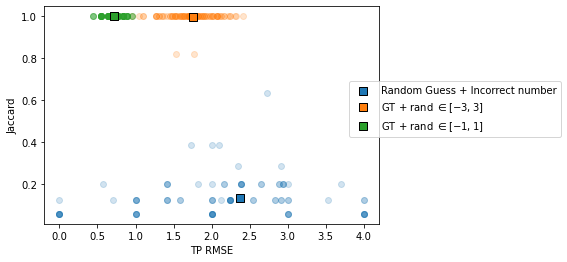

In [40]:
labels = ['Random Guess + Incorrect number',
          r'GT + rand $\in [-3, 3]$',
          r'GT + rand $\in [-1, 1]$']

fig, ax = plt.subplots()
alpha = 0.2

T = 200; ngts = 10; npreds = 8

for case, (label, color) in enumerate(zip(labels, ['C0', 'C1', 'C2'])):
    
    rmse, ji = [], []
    GT, preds = [], []
    for _ in range(100):

        GT.append(np.sort(np.random.choice(np.arange(1,T), ngts, replace = False)))
        if case == 0:
            preds.append(np.sort(np.random.choice(np.arange(1,T), npreds, replace = False)))                  
        elif case == 1:
            preds.append(GT[-1] + np.random.randint(-3, 3, ngts))
        elif case == 2:
            preds.append(GT[-1] + np.random.randint(-1, 1, ngts))

        assignment, _ = changepoint_assignment(GT[-1], preds[-1])
        assignment = np.array(assignment)

        RMSE, JI = changepoint_error(GT[-1], preds[-1], threshold = 5)     
        
        rmse.append(RMSE)
        ji.append(JI)

    rmse_e, ji_e = ensemble_changepoint_error(GT, preds, threshold = 5)
    
    ax.scatter(rmse, ji, c = color, alpha = alpha)
    ax.scatter(rmse_e, ji_e, c = color, label = label, s = 50, marker = 's', edgecolors = 'k')
plt.setp(ax, xlabel = 'TP RMSE', ylabel = 'Jaccard')
ax.legend(loc = (0.91,0.4))

## Segments pairing 
Here we focus on pairing the segments arising from a list of changepoints. We will use this to latter compare the predicted physical properties for each segment

#### `segment_distance`

In [6]:
# export
def segment_distance(seg1, seg2, epsilon = np.nan):
    dist = np.abs(seg1 - seg2)
    dist[dist > epsilon] = epsilon
    return dist

#### `create_binary_segment`

In [5]:
# export
def create_binary_segment(CP, T):
    ''' Given a set of changepoints and the lenght of the trajectory, create segments which are equal to one
    if the segment takes place at that position and zero otherwise '''
    segments = np.zeros((len(CP)+1, T))
    CP = np.append(0, CP)
    for idx, (cp1, cp2) in enumerate(zip(CP[:-1], CP[1:])):
        segments[idx, cp1+1:cp2+1] = 1
    segments[-1, CP[-1]+1:] = 1
    segments[0, 0] = 1
    return segments

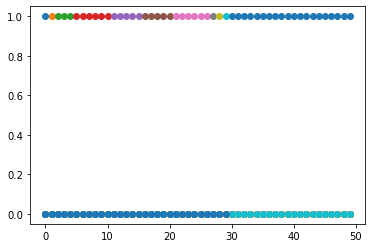

In [4]:
import matplotlib.pyplot as plt
T= 50
GT = np.sort(np.random.choice(np.arange(1,T), 10, replace = False))
for x in create_binary_segment(GT, T):
    plt.plot(x, 'o')

#### `jaccard_between_segments`

In [129]:
# export
def jaccard_between_segments(gt, pred):
    '''Given two segments, calculates the Jaccard index between them by considering TP as correct labeling,
    FN as missed events and FP leftover predictions'''
    
    tp = np.sum(np.logical_and(pred == 1, gt == 1))
    fp = np.sum(np.logical_and(pred == 1, gt == 0))
    fn = np.sum(np.logical_and(pred == 0, gt == 1))
    
    # special case for absence of changepoint
    if tp+fp+fn == 0: return 0    
    else: return jaccard_index(tp, fp, fn)

#### `segment_assignment`

In [19]:
# export
def segment_assignment(GT, preds, T):
    ''' Given a list of groundtruth and predicted changepoints, generates a set of segments. Then constructs 
    a cost matrix by calculting the Jaccard Index between segments. From this cost matrix, we solve the 
    assignment  problem via the Munkres algorithm (aka Hungarian algorithm) and returns two arrays 
    containing the index of the groundtruth and predicted segments, respectively.'''
    
    # Check if the GT or predictions are a single integer or an empty array
    if isinstance(GT, int): GT = [GT]
    elif len(GT) == 0: GT = [T-1]
        
    if isinstance(preds, int): preds = [preds]
    elif len(preds) == 0: preds = [T-1]
    
    seg_GT = create_binary_segment(GT, T)
    seg_preds = create_binary_segment(preds, T)

    cost_matrix = np.zeros((seg_GT.shape[0], seg_preds.shape[0]))

    for idxg, gt in enumerate(seg_GT):
        for idxp, pred in enumerate(seg_preds):
            cost_matrix[idxg, idxp] = 1-jaccard_between_segments(gt, pred)

    return linear_sum_assignment(cost_matrix), cost_matrix

**Easy case**

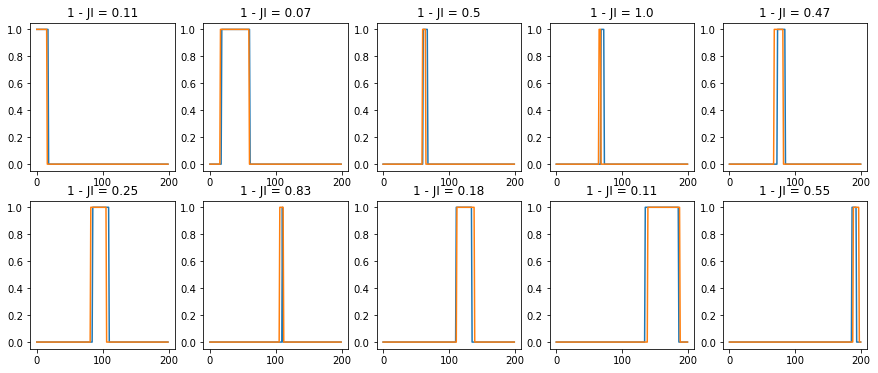

In [72]:
T = 200; 
ngts = 10; 
GT = np.sort(np.random.choice(np.arange(1,T), ngts, replace = False))
preds = np.sort(GT + np.random.randint(-5, 5, ngts) )

seg_GT = create_binary_segment(GT, T)
seg_preds = create_binary_segment(preds, T)   

[row_ind, col_ind], cost_matrix = segment_assignment(GT, preds, T)

fig, axs = plt.subplots(2, 5, figsize = (15, 6))
for r, c, ax in zip(row_ind, col_ind, axs.flatten()):
    ax.set_title(f'1 - JI = {np.round(cost_matrix[r, c], 2)}')
    ax.plot(seg_GT[r])
    ax.plot(seg_preds[c])

**Difficult case**

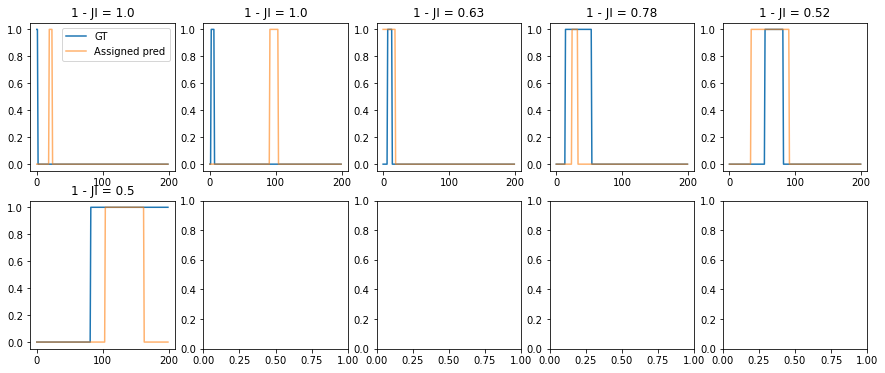

In [71]:
T = 200;
ngts = 5; npreds = 6;
GT = np.sort(np.random.choice(np.arange(1,T), ngts, replace = False))
preds = np.sort(np.random.choice(np.arange(1,T), npreds, replace = False))  

# fig, ax = plt.subplots()
# plt.plot(GT, np.ones(ngts), 'o')
# plt.plot(preds, np.ones(npreds)*0.9, 'o')

seg_GT = create_binary_segment(GT, T)
seg_preds = create_binary_segment(preds, T)

[row_ind, col_ind], cost_matrix = segment_assignment(GT, preds, T)

fig, axs = plt.subplots(2, 5, figsize = (15, 6))
for r, c, ax in zip(row_ind, col_ind, axs.flatten()):
    ax.set_title(f'1 - JI = {np.round(cost_matrix[r, c], 2)}')
    ax.plot(seg_GT[r], label = 'GT')
    ax.plot(seg_preds[c], label = 'Assigned pred', alpha = 0.6)
axs[0,0].legend()

## Segment properties comparison


#### Metrics of segment properties

In [108]:
# export
from sklearn.metrics import mean_squared_log_error, f1_score

def metric_anomalous_exponent(gt, pred):
    # mean absolute error
    return np.mean(np.abs(gt-pred))

def metric_diffusion_coefficient(gt, pred, threshold_min = 1e-12):
    # considering the presence of zeros and negatives
    pred = np.array(pred).copy(); gt = np.array(gt).copy()
    pred[pred <= threshold_min] = threshold_min
    gt[gt <= threshold_min] = threshold_min    
    # mean squared log error
    return mean_squared_log_error(gt, pred)

def metric_diffusive_state(gt, pred):
    return f1_score(gt.astype(int), pred.astype(int), average = 'micro')

#### `check_no_changepoints`


In [185]:
# export
def check_no_changepoints(T,
                          GT_cp, GT_alpha, GT_D, GT_s,
                          preds_cp, preds_alpha, preds_D, preds_s):
    '''Given predicionts over changepoints and variables, checks if in both GT and preds there is an 
    absence of changepoint. If so, takes that into account to pair variables.'''


    if isinstance(GT_cp, int) or isinstance(GT_cp, float):
        GT_cp = [GT_cp]
    if isinstance(preds_cp, int) or isinstance(preds_cp, float):
        preds_cp = [preds_cp]
        
    no_GT_cp = False; no_preds_cp = False
    if len(GT_cp) == 0: no_GT_cp = True
    if len(preds_cp) == 0: no_preds_cp = True

    if no_GT_cp + no_preds_cp == 0:
        return False, None, None, None
    
    else:

        [row_ind, col_ind], _ = segment_assignment(GT_cp, preds_cp, T)   

        if no_GT_cp and not no_preds_cp:
            paired_alpha = np.array([[GT_alpha[0], preds_alpha[col_ind[0]]]])
            paired_D = np.array([[GT_D[0], preds_D[col_ind[0]]]])
            paired_s = np.array([[GT_s[0], preds_s[col_ind[0]]]])

        if no_preds_cp and not no_GT_cp:
            row_position = np.argwhere(col_ind == 0).flatten()[0]            
            paired_alpha = np.array([[GT_alpha[row_position], preds_alpha[col_ind[row_position]]]])
            paired_D = np.array([[GT_D[row_position], preds_D[col_ind[row_position]]]])
            paired_s = np.array([[GT_s[row_position], preds_s[col_ind[row_position]]]])
            
        if no_preds_cp and no_GT_cp: 
            paired_alpha = np.array([[GT_alpha[0], preds_alpha[0]]])
            paired_D = np.array([[GT_D[0], preds_D[0]]])
            paired_s = np.array([[GT_s[0], preds_s[0]]])
            

        return True, paired_alpha, paired_D, paired_s

#### `segment_property_errors`

In [160]:
# export
def segment_property_errors(T, 
                            GT_cp, GT_alpha, GT_D, GT_s,
                            preds_cp, preds_alpha, preds_D, preds_s,
                            return_pairs = False):    
    
    
    
    # Check cases in which changepoint where not detected or there were none in groundtruth
    no_change_point_case, paired_alpha, paired_D, paired_s = check_no_changepoints(T,
                                                                                   GT_cp, GT_alpha, GT_D, GT_s,
                                                                                   preds_cp, preds_alpha, preds_D, preds_s,)
   
    if not no_change_point_case:
        # Solve the assignment problem
        [row_ind, col_ind], _ = segment_assignment(GT_cp, preds_cp, T)


        # iterate over the groundtruth segments
        paired_alpha, paired_D, paired_s = [], [], []
        for idx_seg, (gt_alpha, gt_D) in enumerate(zip(GT_alpha, GT_D)):

            row_position = np.argwhere(row_ind == idx_seg).flatten()

            # if the GT segment was associated to a prediction
            if len(row_position) > 0:
                row_position = int(row_position)
                # alpha
                gt_a_seg = GT_alpha[idx_seg]
                pred_a_seg = preds_alpha[col_ind[row_position]]
                # d
                gt_d_seg = GT_D[idx_seg]
                pred_d_seg = preds_D[col_ind[row_position]]
                # state
                gt_s_seg = GT_s[idx_seg]
                pred_s_seg = preds_s[col_ind[row_position]]

                paired_alpha.append([gt_a_seg, pred_a_seg])
                paired_D.append([gt_d_seg, pred_d_seg])
                paired_s.append([gt_s_seg, pred_s_seg])

        paired_alpha, paired_D, paired_s = np.array(paired_alpha), np.array(paired_D), np.array(paired_s) 
    
    if return_pairs:
        return paired_alpha, paired_D, paired_s 
    else:
        error_alpha = metric_anomalous_exponent(paired_alpha[:,0], paired_alpha[:,1])
        error_D = metric_diffusion_coefficient(paired_D[:,0], paired_D[:,1])
        error_s = metric_diffusive_state(paired_s[:,0], paired_s[:,1])
        return error_alpha, error_D, error_s

In [159]:
T = 200; 
ngts = 10; 
errors_alpha = np.linspace(0, 1, ngts)
errors_d = np.linspace(0, 10, ngts)

metric_a, metric_d = [], []
for error_a, error_d in zip(errors_alpha, errors_d):
    la, ld = [], []
    for _ in range(100):

        GT_cp = np.sort(np.random.choice(np.arange(1,T-1), ngts, replace = False))
        preds_cp = np.sort(np.random.choice(np.arange(1,T-1), ngts, replace = False)) 

        GT_alpha = np.random.rand(GT_cp.shape[0]+1)
        preds_alpha = GT_alpha + np.random.randn(preds_cp.shape[0]+1)*error_a

        GT_D = np.abs(np.random.randn(GT_cp.shape[0]+1)*10)
        preds_D = GT_D + np.abs(np.random.randn(preds_cp.shape[0]+1))*error_d
        
        GT_s = np.random.randint(0, 5, GT_cp.shape[0]+1)
        pred_s = np.random.randint(0, 5, preds_cp.shape[0]+1)

        m_a, m_d, m_s = segment_property_errors(T, GT_cp, GT_alpha, GT_D, GT_s, preds_cp, preds_alpha, preds_D, preds_s)
        
        la.append(m_a); ld.append(m_d)
    
    metric_a.append(np.mean(la))
    metric_d.append(np.mean(ld))

Text(0.5, 1.0, 'Error in $D$')

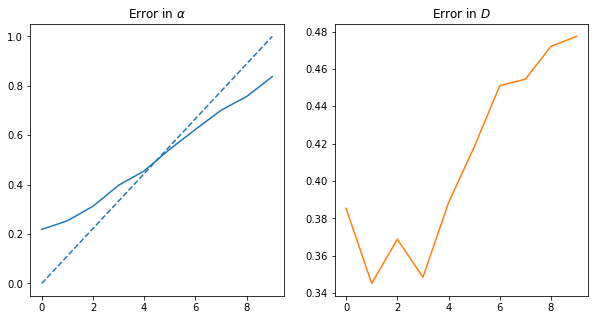

In [161]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(np.arange(ngts), errors_alpha, c = 'C0', ls = '--')
ax[0].plot(np.arange(ngts), metric_a, c = 'C0')
ax[0].set_title(r'Error in $\alpha$')

# ax[1].plot(np.arange(ngts), errors_d, c = 'C1', ls = '--')
ax[1].plot(np.arange(ngts), metric_d, c = 'C1')
ax[1].set_title(r'Error in $D$')

## Ensemble metrics

### Comparing parameter distributions

https://stackoverflow.com/questions/44549369/kullback-leibler-divergence-from-gaussian-pm-pv-to-gaussian-qm-qv

In [7]:
import scipy
from scipy import stats
from scipy.stats import beta as beta_func
import numpy as np
import random

minimum = 1
mode = 2
maximum = 3

d = (minimum + 4*mode + maximum)/6
alpha = 6*((d - minimum)/(maximum - minimum))
beta = 6*((maximum - d)/(maximum - minimum))

location = minimum
scale = maximum - minimum

x = np.arange(-1, 5, 0.001)


pert = beta_func.pdf(x, alpha, beta, location, scale)

In [70]:
import scipy.stats
def multimode_dist(params, weights, bound, x):
    func = scipy.stats.truncnorm
    dist = np.zeros_like(x)
    lower, upper = bound    
    for param, w in zip(params, weights):
        mean, var  = param        
        unimodal = func.pdf(x,
                            (lower-mean)/np.sqrt(var),
                            (upper-mean)/np.sqrt(var),
                            loc = mean,
                            scale = np.sqrt(var))
        dist += w*unimodal
    return dist

In [102]:
params = [[0.5, 0.01], [1.5, 0.01]]
weights = [0.5, 0.5]
true = multimode_dist(params, weights, bound = [0, 2], x = x)


In [100]:
def kl_divergence(p, q):
#     return np.sum(np.where(p != 0, p * np.log(p / q), 0))
    return np.abs(p-q).mean()

In [105]:
np.arange(0, 2, 0.1).shape

(20,)

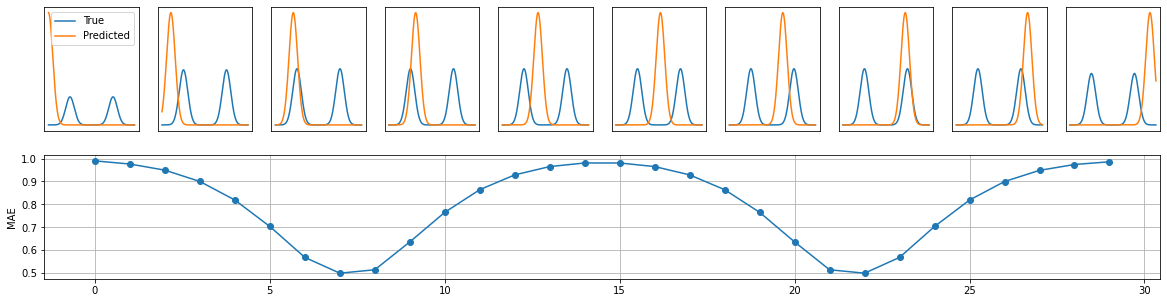

In [108]:
variances = np.linspace(0, 2, 30)

fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(2, 10)



KL = []
for idx, var in enumerate(variances):
    params = [[var, 0.01]]
    weights = [1]
    pred = multimode_dist(params, weights, bound = [0, 2], x = x)  
    KL.append(kl_divergence(true, pred))  
    
    if idx % 3 == 0:
        
        ax = fig.add_subplot(gs[0, int(idx/3)])
        ax.plot(x, true, label = 'True')
        ax.plot(x, pred, label = 'Predicted')        
        plt.setp(ax, yticks = [], xticks = []);
        
      
    if idx == 0:
        ax.legend()
    
ax_kl = fig.add_subplot(gs[1, :])
ax_kl.plot(KL, '-o')
plt.setp(ax_kl, ylabel = 'MAE')
ax_kl.grid()

Text(0.5, 1.0, '2401.668199056616')

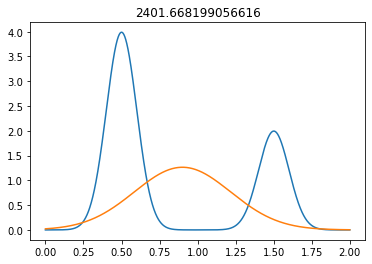

In [51]:
plt.plot(x,true)
plt.plot(x,pred)
plt.title(kl_divergence(true
                        , pred))

Text(0.5, 1.0, '8222.738139198726')

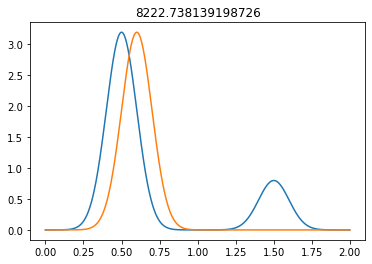

In [73]:
plt.plot(x,true)
plt.plot(x,pred)
plt.title(kl_divergence(true
                        , pred))

Text(0.5, 1.0, '2401.668199056616')

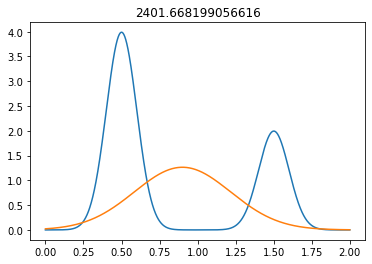

In [51]:
plt.plot(x,true)
plt.plot(x,pred)
plt.title(kl_divergence(true
                        , pred))

In [6]:
pert = scipy.stats.beta.cdf(random_values

print ('pert' + ' ' + str(pert))

impart random [  5560 263462 287357 476978 372852 580575 516517  51155 102246 143536]
intermediate value 248333.33333333334
pert [7.30579253e-07 5.70507873e-01 6.40345505e-01 9.71560514e-01
 8.43733551e-01 9.99567122e-01 9.90069364e-01 2.06522233e-02
 1.01370343e-01 2.03062044e-01]


In [ ]:
x = np.arange(-10, 10, 0.001)
p = norm.pdf(x, 0, 2)
q = norm.pdf(x, 2, 2)
plt.title('KL(P||Q) = %1.3f' % kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red')

In [5]:
pert??

Signature: pert(params, size=1, lamb=4)
Docstring: <no docstring>
Source:   
def pert(params, size=1, lamb=4):
    if isinstance(params, float) or isinstance(params, int):
        if size == 1:
            return params
        else:
            return np.array(params).repeat(size)

    a, b, c = params
    # if all parameters are the same, we consider it a delta distribution
    if a == b == c:
        return np.array([a]*size)
    r = c - a
    alpha = 1 + lamb * (b - a) / r
    beta = 1 + lamb * (c - b) / r
    return a + np.random.beta(alpha, beta, size=size) * r
File:      c:\users\gorka\github\andi_datasets_dev\andi_datasets\utils_trajectories.py
Type:      function


In [1]:
def kl_mvn(m0, S0, m1, S1):
    """
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    

    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

## Reading participants predictions

The participants will have to output predictions in a .txt file were each line corresponds to the predictions of a trajectory. The latter have to be ordered as:

0, d$_0$, a$_0$, s$_0$, t$_1$, d$_1$, a$_1$, s$_1$, t$_2$, d$_2$, a$_2$, s$_2$, .... t$_n$, d$_n$, a$_n$, s$_n$

where the first number corresponds to the trajectory index, then d$_i$, a$_i$, s$_i$ correspond to the diffusion coefficient, anomalous exponent and diffusive state of the $i$-th segment. For the latter, we have the following code:
 - 0: immobile
 - 1: confined
 - 2: brownian
 - 3: anomalous
 
Last, t$_j$ corresponds to the $j$-th changepoints. Each prediction **must** contain $C$ changepoints and $C+1$ segments property values. If this is not fulfilled, the whole trajectory is considered as mispredicted.

The .txt file will be first inspected. The data will then be collected into a dataframe

#### `check_prediction_length`

In [14]:
# export
def check_prediction_length(pred):
    '''Given a trajectory segments prediction, checks whether it has C changepoints and C+1 segments properties values.
    As it must also contain the index of the trajectory, this is summarized by being multiple of 4. '''
    if len(pred) % 4 == 0:
        return True
    else: 
        return False

#### `separate_prediction_values`

In [15]:
# export
def separate_prediction_values(pred):
    '''Given a trajectory segments prediction, extracts the predictions for each segment property as well as the changepoint values'''        
    Ds = pred[1::4]
    alphas = pred[2::4]
    states = pred[3::4]
    cp = pred[4::4]    
    return Ds, alphas, states, cp

#### `load_file_to_df`

In [16]:
# export
def load_file_to_df(path_file, 
                    columns = ['traj_idx', 'Ds', 'alphas', 'states', 'changepoints']):
    '''Given the path of a .txt file, extract the segmentation predictions based on the rules of the ANDI Challenge 2022'''

    with open(path_file) as f:
        lines_pred = f.read().splitlines()

    df = pandas.DataFrame(columns = columns)

    for line in lines_pred:
        # Extract values with comma separator and transform to float
        pred_traj = line.split(',')
        pred = [float(i) for i in pred_traj]
        
        # Check that prediction has the correct shape
        pred_correct = check_prediction_length(pred)
        
        # If correct size, then extract parameters and add it to dataframe
        if pred_correct:
            preds_D, preds_a, preds_s, preds_cp = separate_prediction_values(pred)

            current_row = df.shape[0]
            for param, pred_param in zip(columns, [pred[0], preds_D, preds_a, preds_s, preds_cp]):
                df.loc[current_row, param] = pred_param
                
    return df

Saving fake data for test

In [24]:
file_gt, file_p = [], []
T = 200; ngts = 10;
for traj in range(100):
    GT_cp = np.sort(np.random.choice(np.arange(1,T-5), ngts, replace = False))
    preds_cp = GT_cp #np.sort(np.random.choice(np.arange(1,T), ngts, replace = False)) 

    GT_alpha = np.random.rand(GT_cp.shape[0]+1)
    preds_alpha = GT_alpha# + 0.1 #np.random.randn(preds_cp.shape[0]+1)*0.1

    GT_D = np.abs(np.random.randn(GT_cp.shape[0]+1)*10)
    preds_D = GT_D + 1.5 #np.abs(np.random.randn(preds_cp.shape[0]+1))*1.6
    
    GT_state = np.random.randint(0, high = 5, size = GT_cp.shape[0]+1)
    preds_state = np.random.randint(0, high = 5, size = preds_cp.shape[0]+1)
    
    list_gt, list_p = [traj, GT_D[0], GT_alpha[0], GT_state[0]], [traj, preds_D[0], preds_alpha[0], preds_state[0]]
    for gtc, gta, gtd, gts, pc, pa, pd, ps in zip(GT_cp, GT_alpha[1:], GT_D[1:], GT_state[1:], preds_cp, preds_alpha[1:], preds_D[1:], preds_state[1:]):
        list_gt += [gtc, gtd, gta, gts]
        list_p += [pc, pd, pa, ps]
        
    file_gt.append(list_gt)
    if traj != 6:
        file_p.append(list_p)
        
pred_path, true_path = 'pred_test.txt', 'true_test.txt'
np.savetxt(true_path, file_gt, delimiter=',')
np.savetxt(pred_path, file_p, delimiter=',')

Recovering the data

#### `error_ensemble_prediction`

In [83]:
# export
def error_ensemble_prediction(df_pred, df_true, 
                              threshold_error_alpha = 2, max_val_alpha = 2, min_val_alpha = 0, 
                              threshold_error_D = 1e5, max_val_D = 1e6, min_val_D = 1e-6, # this is in linear scale
                              threshold_error_s = -1, # this will transform nan into non-existing state
                              threshold_cp = 10,
                              prints = True
                             ):
    '''Given two dataframes, corresponding to the predictions and true labels of a set
    of trajectories from the ANDI challenge 2022, calculates the corresponding metrics
    Columns must be for both (no order needed):
    traj_idx | alphas | Ds | changepoints | states
    df_true must also contain a column 'T'
    '''
    
    # Deleter saving variables, just in case...
    try: del paired_alpha, paired_D, paired_s
    except: pass

    # for every trajectory, we stack paired segment properties. We also store changepoints info
    ensemble_pred_cp, ensemble_true_cp = [], []
    for t_idx in tqdm(df_true['traj_idx'].values):

        traj_preds = df_pred.loc[df_pred.traj_idx == t_idx]    
        if traj_preds.shape[0] == 0:
            print('Missing trajectory, what to do?')
            continue

        traj_trues = df_true.loc[df_true.traj_idx == t_idx]
        T = int(traj_trues['T'].values)

        preds_cp, preds_alpha, preds_D, preds_s = [np.array(traj_preds.changepoints.values[0]).astype(int),
                                                   traj_preds.alphas.values[0],
                                                   traj_preds.Ds.values[0],
                                                   traj_preds.states.values[0]]

        trues_cp, trues_alpha, trues_D, trues_s = [np.array(traj_trues.changepoints.values[0]).astype(int),
                                                   traj_trues.alphas.values[0],
                                                   traj_trues.Ds.values[0],
                                                   traj_trues.states.values[0]]


        # collecting changepoints 
        ensemble_pred_cp.append(preds_cp)
        ensemble_true_cp.append(trues_cp)
        
        # collecting segment properties error after segment assignment
        pair_a, pair_d, pair_s = segment_property_errors(T,
                                                         trues_cp, trues_alpha, trues_D, trues_s, 
                                                         preds_cp, preds_alpha, preds_D, preds_s,
                                                         return_pairs = True)

#         print(trues_cp, preds_cp, np.max(pair_a))
        try:
            paired_alpha = np.vstack((paired_alpha, pair_a))
            paired_D = np.vstack((paired_D, pair_d))
            paired_s = np.vstack((paired_s, pair_s))        
        except:
            paired_alpha = pair_a
            paired_D = pair_d
            paired_s = pair_s
            
            
    #### Calculate metrics from assembled properties   

    # checking for nans and problems in predictions
    wrong_alphas = np.argwhere(np.isnan(paired_alpha[:, 1]) | (paired_alpha[:, 1] > 2) | (paired_alpha[:, 1] < 0)).flatten()
    paired_alpha[wrong_alphas, 1] = paired_alpha[wrong_alphas, 0] + threshold_error_alpha

    wrong_ds = np.argwhere(np.isnan(paired_D[:, 1])).flatten()
    paired_D = np.abs(paired_D)
    paired_D[wrong_ds, 1] = paired_D[wrong_ds, 0] + threshold_error_D
    
    wrong_s = np.argwhere((paired_s[:, 1] > 4) | (paired_s[:, 1]<0))
    paired_s[wrong_s, 1] = threshold_error_s    
    
    
    # Changepoints
    rmse_CP, JI = ensemble_changepoint_error(ensemble_true_cp, ensemble_pred_cp, threshold = threshold_cp)

    # Segment properties
    error_alpha = metric_anomalous_exponent(paired_alpha[:,0], paired_alpha[:,1])
    error_D = metric_diffusion_coefficient(paired_D[:,0], paired_D[:,1])
    error_s = metric_diffusive_state(paired_s[:,0], paired_s[:,1])
    
    if prints:
        print(f'Summary of the experiment: \n\nNumber of states: {len(np.unique(paired_alpha[:,0]))} \nExponents: {np.unique(paired_alpha[:,0])} \nDiffusion Coeff.: {np.unique(paired_D[:,0])}',              
              f'\n\nChangepoint Metrics \nRMSE: {round(rmse_CP, 3)} \nJaccard Index: {round(JI, 3)}',
              f'\n\nDiffusion property metrics \nError anomalous exponent: {error_alpha} \nError diffusion coefficient: {error_D} \nError diffusive state: {error_s}')
              
              

    return rmse_CP, JI, error_alpha, error_D, error_s

In [75]:
from andi_datasets.models_phenom import models_phenom

trajs, labels = models_phenom().immobile_traps(T = 200, N = 10, alpha=0.5, D = 1, L = 100, Nt = 1000)

trajs = trajs.transpose((1, 0, 2)).copy()
labels = labels.transpose(1, 0, 2)

df_in, df_out = data_to_df(trajs, labels, label_values=[0.5, 1], diff_states=[3, 2])

  0%|          | 0/199 [00:00<?, ?it/s]

In [62]:
error_ensemble_prediction(df_out, df_out, prints = True)

  0%|          | 0/10 [00:00<?, ?it/s]

Summary of the experiment: 

Number of states: 2 
Exponents: [0.  0.5] 
Diffusion Coeff.: [0. 1.] 

Changepoint Metrics 
RMSE: 0.0 
Jaccard Index: 1.0 

Diffusion property metrics 
Error anomalous exponent: 0.0 
Error diffusion coefficient: 0.0 
Error diffusive state: 1.0


(0.0, 1.0, 0.0, 0.0, 1.0)

# NBDEV Export

In [84]:
from nbdev.export import notebook2script
notebook2script()

Converted datasets_phenom.ipynb.
Converted datasets_theory.ipynb.
Converted models_phenom.ipynb.
Converted models_theory.ipynb.
Converted utils_challenge.ipynb.
Converted utils_trajectories.ipynb.
